In [1]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, BCEWithLogitsLoss
from torch.optim import Adam

from data import BinaryColoredMNIST

from models import Encoder, Classifier, Adversary

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(device)

cpu


### Data Modification

In [3]:
data_dir = "data/mnist_data"
dataset1 = BinaryColoredMNIST(root=data_dir, p_even_red=0.8, p_odd_red=0.7, prob_a=0.5)

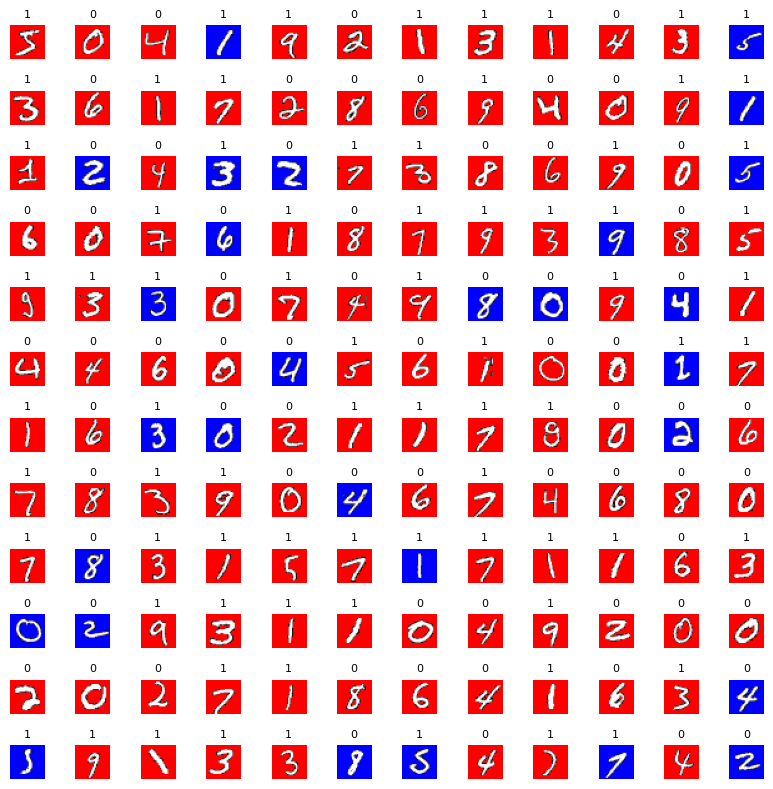

In [4]:
data = dataset1[:144]

plt.figure(figsize=(8, 8))

for i, (img, a, label) in enumerate(data):
    plt.subplot(12, 12, i + 1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.title(str(label.item()), fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Setup for DP

C = 2
learning_rate = 1e-3
gamma = 1 / C

encoder = Encoder(10).to(device)
classifier = Classifier(10).to(device)
adv = Adversary(10).to(device)

adversaries = ModuleList([adv for _ in range(C)])

criterion_class = BCEWithLogitsLoss()

optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

optimizer_adv = Adam(adv.parameters(), lr=learning_rate / C)
optimizers_adv = [optimizer_adv for _ in range(C)]

train_loader  = torch.utils.data.DataLoader(
    dataset1, batch_size=64, shuffle=True, num_workers=4
)

In [6]:
from train import train_laftr
train_laftr(encoder, classifier, adversaries, criterion_class, optimizer_enc_class, optimizers_adv, train_loader, gamma, device=device, verbose=True)

Epoch 0 (encoder+classifier loss: -2.0868, adversary loss: 4.7867)
Epoch 1 (encoder+classifier loss: -2.3102, adversary loss: 4.9383)
Epoch 2 (encoder+classifier loss: -2.5544, adversary loss: 5.3283)
Epoch 3 (encoder+classifier loss: -1.9120, adversary loss: 4.0201)


KeyboardInterrupt: 